<h1>Airbnb listing data for NYC 2019</h1>

<p>Airbnb is one of the largest short-term rental services in the world.  As such, they have millions of listings, many of which are in metropolitan areas like LA and NYC.  They currently do not have a public API to get listing data, but fortunately a recent <a href=https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data>dataset</a> is available on Kaggle specifically for NYC, and the raw source for this data can be found <a href="http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/listings.csv.gz">here</a>.  Data for other cities can also be found <a href="http://insideairbnb.com/get-the-data.html">here</a>.</p>

<p>Let's take a look at the <b>listings.csv</b> first, then we'll get to the time series data in <b>calendar.csv</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
listings_df = pd.read_csv('listings.csv')

/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<br/>
<p>There are certain columns that have mixed data. Lets take a look at the general structure of the listings as well as those columns.</p>

In [2]:
print(listings_df.info())
print(listings_df.columns)
for col_index in [60, 61, 93, 94]:
    print(listings_df.columns[col_index])
listings_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(21), object(63)
memory usage: 40.9+ MB
None
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)
price
weekly_price
requires_license
license


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20191204162729,2019-12-07,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.39
1,3831,https://www.airbnb.com/rooms/3831,20191204162729,2019-12-07,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.67
2,5099,https://www.airbnb.com/rooms/5099,20191204162729,2019-12-06,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.60
3,5121,https://www.airbnb.com/rooms/5121,20191204162729,2019-12-06,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.38
4,5178,https://www.airbnb.com/rooms/5178,20191204162729,2019-12-05,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...",Please don’t expect the luxury here just a bas...,none,"Theater district, many restaurants around here.",...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,3.52


<br/>
<p>As we will see later, those mixed columns are not necessary.  There are also more entries than in the first dataset that we looked at (hopefully for more accurate modeling).  Let's drop the mixed columns and other columns that have irrelevant data, majority incomplete data, or data that can be found in other tables.</p>

In [3]:
# calendar values scraped in a small window between 2019-12-04 and 2019-12-07

listings_clean = listings_df.drop(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', \
    'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', \
    'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', \
    'host_name', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', \
    'host_acceptance_rate', 'host_since', 'host_listings_count', 'host_total_listings_count', \
    'host_verifications', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic', \
    'host_identity_verified', 'host_neighbourhood', 'street', 'neighbourhood', 'city', 'state', 'zipcode', \
    'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'instant_bookable', \
    'is_business_travel_ready', 'license', 'jurisdiction_names', 'review_scores_value', 'requires_license', \
    'review_scores_communication', 'bed_type', 'amenities', 'weekly_price', 'monthly_price', \
    'security_deposit', 'guests_included', 'minimum_minimum_nights', 'maximum_minimum_nights', \
    'minimum_maximum_nights', 'maximum_maximum_nights', 'calendar_updated', 'has_availability', \
    'calendar_last_scraped', 'number_of_reviews_ltm', 'first_review', 'last_review', 'review_scores_accuracy', \
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_location', 'cancellation_policy', \
    'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', \
    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', \
    'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'cleaning_fee', 'extra_people', \
    'number_of_reviews', 'review_scores_rating', 'square_feet', 'property_type', 'minimum_nights_avg_ntm', \
    'maximum_nights_avg_ntm', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', \
    'availability_60', 'availability_90', 'availability_365'], axis=1)
print(listings_clean.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Data columns (total 10 columns):
id                              50599 non-null int64
neighbourhood_cleansed          50599 non-null object
neighbourhood_group_cleansed    50599 non-null object
latitude                        50599 non-null float64
longitude                       50599 non-null float64
room_type                       50599 non-null object
accommodates                    50599 non-null int64
bathrooms                       50548 non-null float64
bedrooms                        50536 non-null float64
beds                            50467 non-null float64
dtypes: float64(5), int64(2), object(3)
memory usage: 3.9+ MB
None


<br/>
<p>Columns <b>bathrooms, bedrooms, beds</b> have missing data, but thankfully not a lot.  We will try to clean that up.  Let's also rename a couple columns</p>

In [4]:
listings_clean.rename(columns={
    'neighbourhood_cleansed':'neighbourhood',
    'neighbourhood_group_cleansed': 'neighbourhood_group'
}, inplace=True)
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Data columns (total 10 columns):
id                     50599 non-null int64
neighbourhood          50599 non-null object
neighbourhood_group    50599 non-null object
latitude               50599 non-null float64
longitude              50599 non-null float64
room_type              50599 non-null object
accommodates           50599 non-null int64
bathrooms              50548 non-null float64
bedrooms               50536 non-null float64
beds                   50467 non-null float64
dtypes: float64(5), int64(2), object(3)
memory usage: 3.9+ MB


<br/>
<p>We see some possible outliers for <b>accommodates, bathrooms, bedrooms, beds</b>.</p>

In [5]:
listings_clean.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds
count,5.059900e+04,50599.000000,50599.000000,50599.000000,50548.000000,50536.000000,50467.000000
mean,2.137380e+07,40.728743,-73.950762,2.860630,1.150332,1.181217,1.549626
std,1.242864e+07,0.055004,0.047606,1.900865,0.442102,0.760981,1.131406
min,2.595000e+03,40.499790,-74.247870,1.000000,0.000000,0.000000,0.000000
25%,1.009891e+07,40.689550,-73.982930,2.000000,1.000000,1.000000,1.000000
50%,2.154642e+07,40.722880,-73.955050,2.000000,1.000000,1.000000,1.000000
75%,3.271780e+07,40.763030,-73.934200,4.000000,1.000000,1.000000,2.000000
max,4.058402e+07,40.916860,-73.712990,25.000000,15.500000,21.000000,40.000000


<br/>
<p>Check for duplicate latitude and longitude value pairs, which most likely means duplicate listings</p>

In [6]:
# https://stackoverflow.com/questions/44481768/remove-duplicate-rows-from-pandas-dataframe-where-only-some-columns-have-the-sam
# https://stackoverflow.com/questions/16167829/in-pandas-how-can-i-reset-index-without-adding-a-new-column

listings_clean = listings_clean.drop_duplicates(subset=['latitude', 'longitude']).reset_index(drop=True)
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50587 entries, 0 to 50586
Data columns (total 10 columns):
id                     50587 non-null int64
neighbourhood          50587 non-null object
neighbourhood_group    50587 non-null object
latitude               50587 non-null float64
longitude              50587 non-null float64
room_type              50587 non-null object
accommodates           50587 non-null int64
bathrooms              50536 non-null float64
bedrooms               50524 non-null float64
beds                   50455 non-null float64
dtypes: float64(5), int64(2), object(3)
memory usage: 3.9+ MB


<br/>
<p>Look at non-numerical columns to see if they can be categorized.</p>

In [7]:
# http://benalexkeen.com/mapping-categorical-data-in-pandas/

print(listings_clean.room_type.value_counts())
print(listings_clean.neighbourhood_group.value_counts())
print(listings_clean.neighbourhood.value_counts())


Entire home/apt    26134
Private room       22780
Shared room         1256
Hotel room           417
Name: room_type, dtype: int64
Manhattan        22062
Brooklyn         20736
Queens            6196
Bronx             1215
Staten Island      378
Name: neighbourhood_group, dtype: int64
Bedford-Stuyvesant            3973
Williamsburg                  3933
Harlem                        2746
Bushwick                      2504
Hell's Kitchen                2052
                              ... 
Willowbrook                      1
Woodrow                          1
Bay Terrace, Staten Island       1
New Dorp                         1
Fort Wadsworth                   1
Name: neighbourhood, Length: 223, dtype: int64


In [8]:
home_listings = listings_clean.loc[listings_clean.room_type == 'Entire home/apt']
print(home_listings.bedrooms.value_counts())
print(home_listings.beds.value_counts())
print(home_listings.bathrooms.value_counts())

1.0     13018
2.0      6214
0.0      4140
3.0      2034
4.0       476
5.0       133
6.0        41
7.0        17
8.0        10
10.0        5
9.0         4
21.0        1
14.0        1
12.0        1
Name: bedrooms, dtype: int64
1.0     11605
2.0      8097
3.0      3258
4.0      1428
0.0       697
5.0       521
6.0       243
7.0       104
8.0        54
9.0        36
10.0       16
11.0       14
12.0       11
13.0        7
14.0        4
16.0        3
18.0        2
17.0        2
15.0        1
26.0        1
40.0        1
21.0        1
22.0        1
Name: beds, dtype: int64
1.0     22189
2.0      2255
1.5       889
2.5       339
3.0       208
3.5        77
4.0        49
0.0        37
0.5        26
4.5        23
5.0        13
6.0         5
5.5         4
7.0         2
8.0         1
7.5         1
6.5         1
15.5        1
Name: bathrooms, dtype: int64


<p>We see some outliers that may skew any modeling, so let's remove any listing over 10 <b>bedrooms</b>, 12 <b>beds</b>, and 5 <b>bathrooms</b>.  Realistically the vast majority of property owners are not listing super mansions.</p>

In [9]:
listings_clean = listings_clean.loc[
    (listings_clean.bedrooms <= 10) & (listings_clean.beds <=12) & (listings_clean.bathrooms <= 5)
]

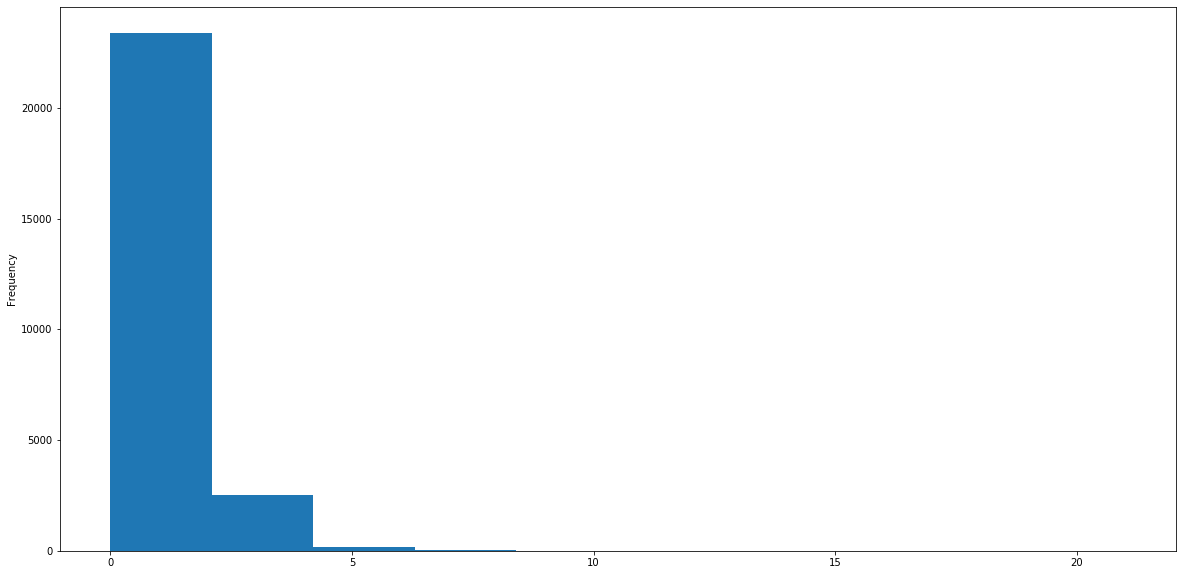

In [10]:
home_listings.bedrooms.plot(kind='hist', figsize=(20, 10))

<p>Home listings are heavily skewed toward single bedroom.  Perhaps we can approximate <b>bedrooms, bathrooms, beds</b> as exponential distributions.</p>
<p>Let's do the same analysis for single room type listings</p>

In [11]:
room_listings = listings_clean.loc[listings_clean.room_type != 'Entire home/apt']
print(room_listings.bedrooms.value_counts())
print(room_listings.beds.value_counts())
print(room_listings.bathrooms.value_counts())

1.0    23006
2.0      572
0.0      502
3.0      124
4.0       48
6.0       11
5.0        7
8.0        1
Name: bedrooms, dtype: int64
1.0     20031
2.0      2597
0.0       785
3.0       533
4.0       216
5.0        43
6.0        36
7.0        14
12.0        6
8.0         6
11.0        2
10.0        1
9.0         1
Name: beds, dtype: int64
1.0    20302
2.0     1852
1.5     1590
3.0      160
2.5      137
0.0       81
0.5       77
4.0       47
3.5       20
5.0        4
4.5        1
Name: bathrooms, dtype: int64


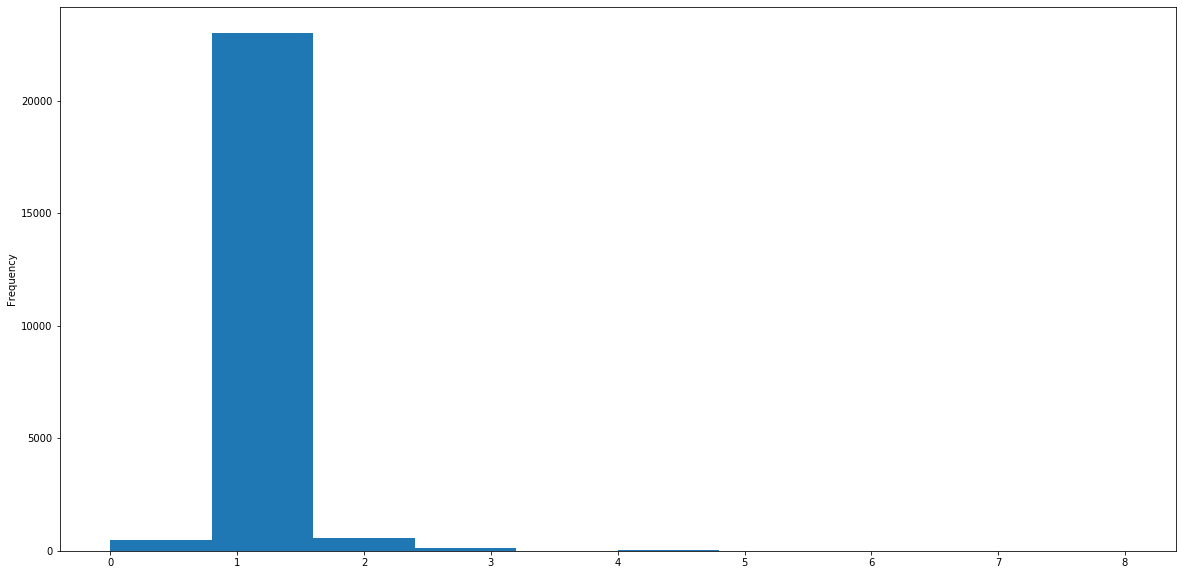

In [12]:
room_listings.bedrooms.plot(kind='hist', figsize=(20, 10))

<p>We get similar results to home listings, which is odd.  Perhaps some single room type listings were incorrectly listed.  That means we may not be able to rely on <b>room_type</b> as a feature.</p>

<p>Let's do some data cleaning by filling in the missing <b>bedrooms, bathrooms, beds</b> values (disregarding homes/apts vs. single room since <b>room_type</b> is not always indicative of multiple rooms vs. one room).  0 values can still be considered valid (e.g. studio apt, shared living area, shared bathroom, non-bed type sleeping arrangment).  We will assume that 0.001 degree latitude or longitude <a href=https://gizmodo.com/how-precise-is-one-degree-of-longitude-or-latitude-1631241162">is about 100 m</a>.  Let's average over an area of 200 m radius from listings that have missing data.  We will group by <b>neighbourhood</b> when calculating the mean.</p>

In [13]:
lat_diff = 0.002
long_diff = 0.002
def avg_of_neighbors(row, col_name, col_index):
    item = row[col_index]
    room_type = row[5]
    lat = row[3]
    long = row[4]
    if math.isnan(item):
        item = listings_clean[col_name].loc[(listings_clean.latitude > lat - lat_diff) \
            & (listings_clean.latitude < lat + lat_diff) \
            & (listings_clean.longitude > long - long_diff) \
            & (listings_clean.longitude < long + long_diff)].groupby(by=listings_clean.neighbourhood).mean().round()[0]
        if item == 0:
            item = 1
        row[col_index] = item
    return row

listings_clean = listings_clean.apply(avg_of_neighbors, col_name='bathrooms', col_index=7, axis=1)
listings_clean = listings_clean.apply(avg_of_neighbors, col_name='bedrooms', col_index=8, axis=1)
listings_clean = listings_clean.apply(avg_of_neighbors, col_name='beds', col_index=9, axis=1)

In [14]:
print(listings_clean.bedrooms.value_counts())
print(listings_clean.bathrooms.value_counts())
print(listings_clean.beds.value_counts())

1.0     35998
2.0      6780
0.0      4638
3.0      2153
4.0       522
5.0       131
6.0        46
7.0        13
8.0         8
10.0        2
9.0         2
Name: bedrooms, dtype: int64
1.0    42432
2.0     4104
1.5     2479
2.5      472
3.0      363
0.0      116
0.5      103
3.5       95
4.0       91
4.5       24
5.0       14
Name: bathrooms, dtype: int64
1.0     31597
2.0     10683
3.0      3791
4.0      1644
0.0      1482
5.0       561
6.0       278
7.0       118
8.0        59
9.0        36
11.0       16
12.0       14
10.0       14
Name: beds, dtype: int64


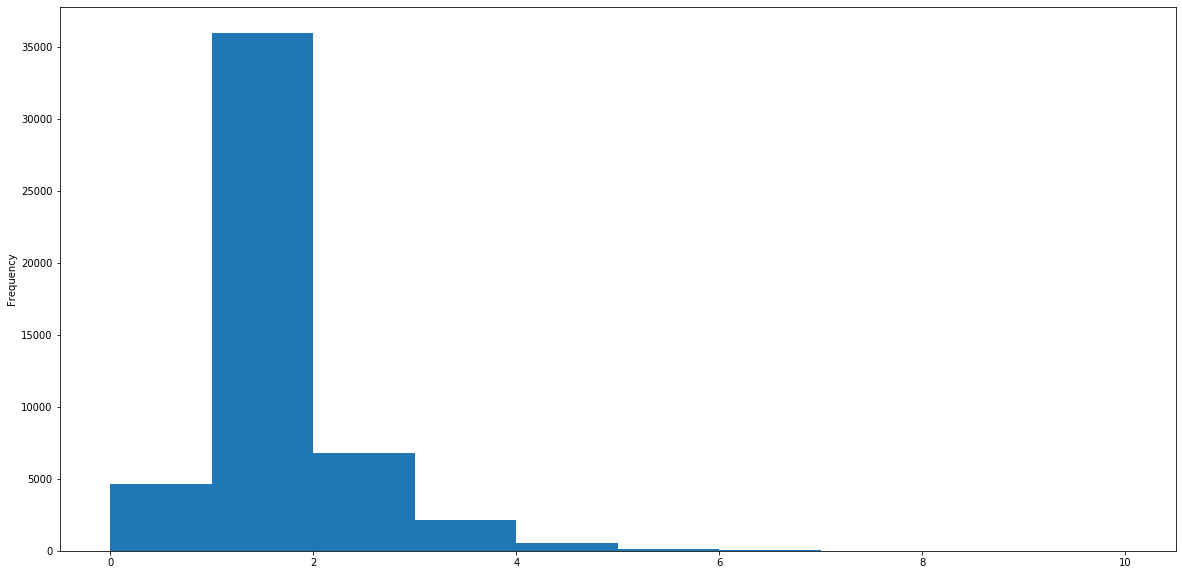

In [15]:
listings_clean.bedrooms.plot(kind='hist', figsize=(20, 10))

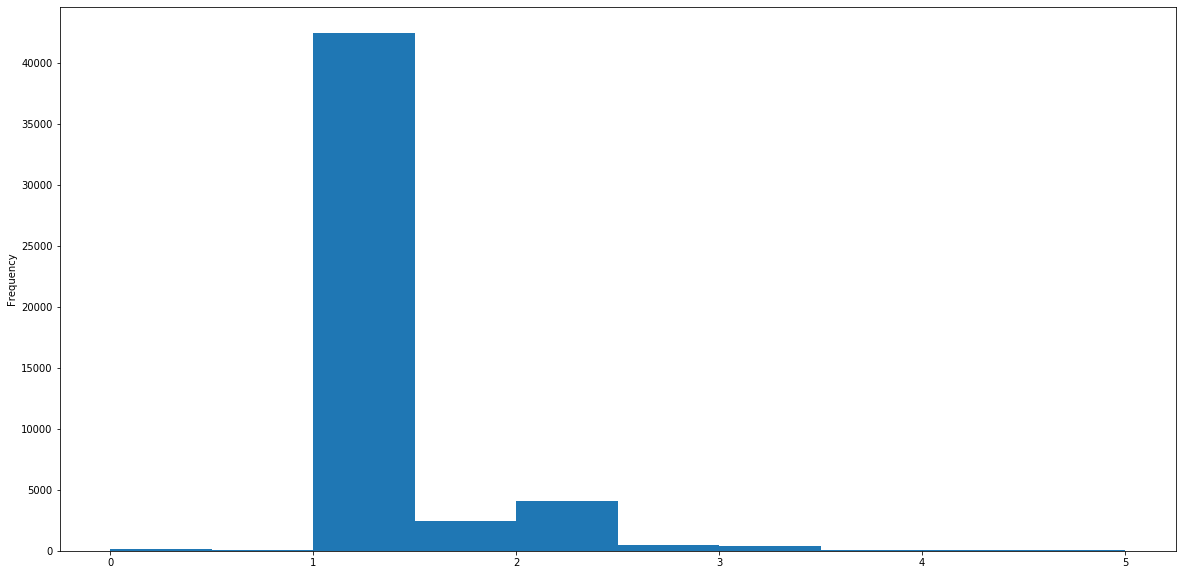

In [16]:
listings_clean.bathrooms.plot(kind='hist', figsize=(20, 10))

<p>After <b>bedrooms, bathrooms, beds</b> cleanup, we are able to see a bit more detail in the distributions.  They are approximately exponential (again skewed toward 1).</p>

<p>Final check on the listings for any missing data.</p>

In [17]:
listings_clean.info()
print(listings_clean.neighbourhood_group.value_counts())
print(listings_clean.neighbourhood.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50293 entries, 0 to 50586
Data columns (total 10 columns):
id                     50293 non-null int64
neighbourhood          50293 non-null object
neighbourhood_group    50293 non-null object
latitude               50293 non-null float64
longitude              50293 non-null float64
room_type              50293 non-null object
accommodates           50293 non-null int64
bathrooms              50293 non-null float64
bedrooms               50293 non-null float64
beds                   50293 non-null float64
dtypes: float64(5), int64(2), object(3)
memory usage: 4.2+ MB
Manhattan        21958
Brooklyn         20592
Queens            6160
Bronx             1207
Staten Island      376
Name: neighbourhood_group, dtype: int64
Bedford-Stuyvesant            3950
Williamsburg                  3912
Harlem                        2728
Bushwick                      2474
Hell's Kitchen                2043
                              ... 
Fort Wadswo

<br/>
<p>Now let's take a look at the time series data for availability, price, and nights.  <a href=http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/calendar.csv.gz><b>Calendar.csv</b></a> comes from the same <a href="http://insideairbnb.com/get-the-data.html">source</a> as <b>listings.csv</b></p>.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
calendar_df = pd.read_csv('calendar.csv', parse_dates=['date'])

<br/>
<p>This time we don't have to deal with columns of mixed data, nor do we have a large number of columns like in the <b>listings_clean</b> table.  We do, however, have over 18 million entries, which makes sense given that this is time series data over a year for 50,000+ listings.  We will have to clean up availability and price.</p>

In [19]:
print(calendar_df.info())
print(calendar_df.columns)
calendar_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18470156 entries, 0 to 18470155
Data columns (total 7 columns):
listing_id        int64
date              datetime64[ns]
available         object
price             object
adjusted_price    object
minimum_nights    float64
maximum_nights    float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 986.4+ MB
None
Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,19812,2019-12-05,f,$105.00,$105.00,3.0,90.0
1,2595,2019-12-06,f,$175.00,$175.00,10.0,1125.0
2,2595,2019-12-07,f,$175.00,$175.00,10.0,1125.0
3,2595,2019-12-08,f,$175.00,$175.00,10.0,1125.0
4,2595,2019-12-09,f,$175.00,$175.00,10.0,1125.0


<br/>
<p>On checking for equal distribution of all listings over the relevant time period (assumed for this step to be a year), we see a problem with <b>listing_id</b> 15268792.  Let's just remove it, since it is not worth the effort to build a year's worth of data for that one listing.</p>

In [20]:
print(calendar_df.listing_id.value_counts())
calendar_clean = calendar_df[calendar_df.listing_id != 15268792]


25512622    368
32678719    368
28138840    368
30069091    368
24285044    368
           ... 
27926502    365
18992796    365
21677053    365
30226855    365
15268792      6
Name: listing_id, Length: 50599, dtype: int64


<br/>
<p>Since this data set was captured in 2019, we must clean up dates that have year 2020.  Then drop any duplicate <b>listing_id, date</b> combos.  Then check that all days add up to a calendar year for each <b>listing_id</b>.</p>

In [21]:
# https://stackoverflow.com/questions/50674011/replace-the-year-in-pandas-datetime-column
# https://stackoverflow.com/questions/28773342/truncate-timestamp-column-to-hour-precision-in-pandas-dataframe

calendar_clean['date'] = calendar_clean['date'].mask(calendar_clean['date'].dt.year == 2020,
                            calendar_clean['date'] - pd.to_timedelta(365, unit='D') + pd.to_timedelta(12, unit='h'))
calendar_clean['date'] = calendar_clean['date'].dt.floor('D')

<ipython-input-21-9b6d71aa0642>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean['date'] = calendar_clean['date'].mask(calendar_clean['date'].dt.year == 2020,
<ipython-input-21-9b6d71aa0642>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_clean['date'] = calendar_clean['date'].dt.floor('D')


In [22]:
calendar_clean = calendar_clean.drop_duplicates(subset=['listing_id', 'date']).reset_index(drop=True)
print(calendar_clean.listing_id.value_counts())

327521      365
7756711     365
31877537    365
14961122    365
201992      365
           ... 
37055580    365
13186007    365
18549136    365
34646244    365
30226855    365
Name: listing_id, Length: 50598, dtype: int64


<br/>
<p>Verify that all listing_id values can be found in the <b>listings_clean</b> table.  If not, then remove rows with listing_id values don't exist in the other table.</p>

In [23]:
# https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe

ids_match = calendar_clean.listing_id.isin(listings_clean.id)
print(ids_match.value_counts())

True     18356580
False      111690
Name: listing_id, dtype: int64


In [24]:
calendar_clean = calendar_clean[calendar_clean.listing_id.isin(listings_clean.id)]
calendar_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18356580 entries, 0 to 18468269
Data columns (total 7 columns):
listing_id        int64
date              datetime64[ns]
available         object
price             object
adjusted_price    object
minimum_nights    float64
maximum_nights    float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.1+ GB


<br/>
<p>Translate all <b>available</b> values to 1 (available) or 0 (unavailable).</p>

In [25]:
print(calendar_clean.available.value_counts())
calendar_clean['available'] = np.where(calendar_clean.available == 't', 1, 0)
print(calendar_clean.available.value_counts())

f    12263515
t     6093065
Name: available, dtype: int64
0    12263515
1     6093065
Name: available, dtype: int64


<br/>
<p>Less than 1% of the entries have <b>adjusted_price</b> not equal to <b>price</b>, but we will use <b>adjusted_price</b> anyway and clean it up to be numerical</p>

In [26]:
calendar_clean[calendar_clean.price != calendar_clean.adjusted_price]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
8232,20734,2019-12-06,0,$134.00,$127.00,3.0,29.0
8419,20734,2019-12-07,0,$134.00,$127.00,3.0,29.0
8420,20734,2019-12-08,0,$134.00,$127.00,3.0,29.0
8421,20734,2019-12-09,0,$134.00,$127.00,3.0,29.0
8422,20734,2019-12-10,0,$134.00,$127.00,3.0,29.0
...,...,...,...,...,...,...,...
18402175,40482221,2019-12-01,0,$74.00,$63.00,1.0,365.0
18402176,40482221,2019-12-02,0,$74.00,$63.00,1.0,365.0
18402177,40482221,2019-12-03,0,$74.00,$63.00,1.0,365.0
18402178,40482221,2019-12-04,0,$74.00,$63.00,1.0,365.0


In [27]:
calendar_clean['price_cleansed'] = calendar_clean.adjusted_price\
.str.replace('$', '').str.replace(',', '').astype('float')

In [28]:
calendar_clean = calendar_clean.drop(['adjusted_price', 'price'], axis=1)
calendar_clean.rename(columns={'price_cleansed': 'price'}, inplace=True)

<br/>
<p>Now is a good time to check the state of the table.  All columns except for <b>maximum_nights</b> seem to have useful data.  The large majority of listings allowing over 1000 nights for a short-term rental means that, for practical purposes, it is limitless.</p>

In [29]:
calendar_clean.info()
calendar_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18356580 entries, 0 to 18468269
Data columns (total 6 columns):
listing_id        int64
date              datetime64[ns]
available         int64
minimum_nights    float64
maximum_nights    float64
price             float64
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 980.3 MB


,listing_id,date,available,minimum_nights,maximum_nights,price
0,19812,2019-12-05,0,3.0,90.0,105.0
1,2595,2019-12-06,0,10.0,1125.0,175.0
2,2595,2019-12-07,0,10.0,1125.0,175.0
3,2595,2019-12-08,0,10.0,1125.0,175.0
4,2595,2019-12-09,0,10.0,1125.0,175.0


In [30]:
calendar_clean.describe()

,listing_id,available,minimum_nights,maximum_nights,price
count,1.835658e+07,1.835658e+07,1.835592e+07,1.835592e+07,1.835568e+07
mean,2.134300e+07,3.319281e-01,8.515964e+00,6.929518e+05,1.561830e+02
std,1.239563e+07,4.709054e-01,3.030353e+01,3.853047e+07,2.690733e+02
min,2.595000e+03,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.009977e+07,0.000000e+00,1.000000e+00,2.900000e+01,6.900000e+01
50%,2.150508e+07,0.000000e+00,3.000000e+00,1.125000e+03,1.090000e+02
75%,3.266455e+07,1.000000e+00,5.000000e+00,1.125000e+03,1.790000e+02
max,4.058402e+07,1.000000e+00,3.456000e+03,2.147484e+09,1.000000e+04


In [31]:
calendar_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18356580 entries, 0 to 18468269
Data columns (total 6 columns):
listing_id        int64
date              datetime64[ns]
available         int64
minimum_nights    float64
maximum_nights    float64
price             float64
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 980.3 MB


<br/>
<p>Since travel patterns are usually seasonal, let's average availability, min nights required, and price over each season and the whole year.</p>

In [32]:
available_year_avg = calendar_clean.groupby(by='listing_id').available.mean()
available_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id').available.mean()
available_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id').available.mean()
available_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id').available.mean()
available_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id').available.mean()
available_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id').available.mean()
available_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id').available.mean()
available_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id').available.mean()

calendar_averages = pd.DataFrame(available_year_avg)
calendar_averages.rename(columns={'available': 'available_year_avg'}, inplace=True)
calendar_averages['available_winter_avg'] = available_winter_avg
calendar_averages['available_spring_avg'] = available_spring_avg
calendar_averages['available_summer_avg'] = available_summer_avg
calendar_averages['available_fall_avg'] = available_fall_avg
calendar_averages['available_jan_avg'] = available_jan_avg
calendar_averages['available_jun_avg'] = available_jun_avg
calendar_averages['available_dec_avg'] = available_dec_avg


In [34]:
min_nights_year_avg = calendar_clean.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id')['minimum_nights'].mean()

calendar_averages['min_nights_year_avg'] = min_nights_year_avg
calendar_averages['min_nights_winter_avg'] = min_nights_winter_avg
calendar_averages['min_nights_spring_avg'] = min_nights_spring_avg
calendar_averages['min_nights_summer_avg'] = min_nights_summer_avg
calendar_averages['min_nights_fall_avg'] = min_nights_fall_avg
calendar_averages['min_nights_jan_avg'] = min_nights_jan_avg
calendar_averages['min_nights_jun_avg'] = min_nights_jun_avg
calendar_averages['min_nights_dec_avg'] = min_nights_dec_avg

In [35]:
price_year_avg = calendar_clean.groupby(by='listing_id')['price'].mean()
price_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id')['price'].mean()
price_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id')['price'].mean()
price_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id')['price'].mean()
price_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id')['price'].mean()
price_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id')['price'].mean()
price_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id')['price'].mean()
price_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id')['price'].mean()

calendar_averages['price_year_avg'] = price_year_avg
calendar_averages['price_winter_avg'] = price_winter_avg
calendar_averages['price_spring_avg'] = price_spring_avg
calendar_averages['price_summer_avg'] = price_summer_avg
calendar_averages['price_fall_avg'] = price_fall_avg
calendar_averages['price_jan_avg'] = price_jan_avg
calendar_averages['price_jun_avg'] = price_jun_avg
calendar_averages['price_dec_avg'] = price_dec_avg

In [36]:
calendar_averages.info()
calendar_averages.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50292 entries, 2595 to 40584021
Data columns (total 24 columns):
available_year_avg       50292 non-null float64
available_winter_avg     50292 non-null float64
available_spring_avg     50292 non-null float64
available_summer_avg     50292 non-null float64
available_fall_avg       50292 non-null float64
available_jan_avg        50292 non-null float64
available_jun_avg        50292 non-null float64
available_dec_avg        50292 non-null float64
min_nights_year_avg      50292 non-null float64
min_nights_winter_avg    50292 non-null float64
min_nights_spring_avg    50292 non-null float64
min_nights_summer_avg    50292 non-null float64
min_nights_fall_avg      50292 non-null float64
min_nights_jan_avg       50292 non-null float64
min_nights_jun_avg       50292 non-null float64
min_nights_dec_avg       50292 non-null float64
price_year_avg           50292 non-null float64
price_winter_avg         50292 non-null float64
price_spring_avg     

,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,available_jan_avg,available_jun_avg,available_dec_avg,min_nights_year_avg,min_nights_winter_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,50292.000000,50292.000000,50292.000000,50292.000000,50292.000000,50292.000000,50292.000000,50292.000000,50292.000000,50292.000000,...,50292.000000,50292.000000,50292.000000,50292.000000,50290.000000,50292.000000,50289.000000,50290.000000,50292.000000,50292.000000
mean,0.331928,0.375657,0.373142,0.299477,0.279821,0.424652,0.300025,0.247455,8.515889,7.989934,...,8.768183,7.675984,156.182761,149.663200,155.139477,157.489386,162.367411,145.984499,158.079011,156.537024
std,0.375284,0.370911,0.449863,0.443657,0.443552,0.445963,0.442001,0.300039,28.860220,25.753750,...,33.708607,23.604330,247.443541,239.777276,247.976157,245.599685,300.599259,239.722520,246.556127,245.392756
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.287671,1.288889,...,1.266667,1.290323,69.000000,66.388889,68.804348,70.000000,70.000000,65.064516,70.000000,68.935484
50%,0.172603,0.288889,0.043478,0.000000,0.000000,0.161290,0.000000,0.129032,2.983562,2.955556,...,3.000000,2.903226,109.417808,105.961111,109.000000,110.000000,110.000000,103.225806,110.000000,110.000000
75%,0.684932,0.733333,1.000000,0.989130,1.000000,0.935484,1.000000,0.419355,5.000000,5.000000,...,5.000000,5.000000,180.000000,175.000000,180.000000,180.135870,180.000000,170.000000,180.333333,180.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1494.104110,1997.166667,...,3337.000000,1574.225806,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


<p>1000+ <b>minimum_nights</b> is extremely high and unrealistic.</p>

<p>Let's drop any entry that averages over 30 minimum nights.</p>

In [37]:
calendar_averages = calendar_averages.loc[
    (calendar_averages.min_nights_year_avg <= 30) & 
    (calendar_averages.min_nights_winter_avg <= 30) &
    (calendar_averages.min_nights_spring_avg <= 30) &
    (calendar_averages.min_nights_summer_avg <= 30) &
    (calendar_averages.min_nights_fall_avg <= 30) &
    (calendar_averages.min_nights_jan_avg <= 30) &
    (calendar_averages.min_nights_jun_avg <= 30) &
    (calendar_averages.min_nights_dec_avg <= 30)
]

In [38]:
calendar_averages.info()
calendar_averages.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49093 entries, 2595 to 40584021
Data columns (total 24 columns):
available_year_avg       49093 non-null float64
available_winter_avg     49093 non-null float64
available_spring_avg     49093 non-null float64
available_summer_avg     49093 non-null float64
available_fall_avg       49093 non-null float64
available_jan_avg        49093 non-null float64
available_jun_avg        49093 non-null float64
available_dec_avg        49093 non-null float64
min_nights_year_avg      49093 non-null float64
min_nights_winter_avg    49093 non-null float64
min_nights_spring_avg    49093 non-null float64
min_nights_summer_avg    49093 non-null float64
min_nights_fall_avg      49093 non-null float64
min_nights_jan_avg       49093 non-null float64
min_nights_jun_avg       49093 non-null float64
min_nights_dec_avg       49093 non-null float64
price_year_avg           49093 non-null float64
price_winter_avg         49093 non-null float64
price_spring_avg     

,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,available_jan_avg,available_jun_avg,available_dec_avg,min_nights_year_avg,min_nights_winter_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,...,49093.000000,49093.000000,49093.000000,49093.000000,49091.000000,49093.000000,49090.000000,49091.000000,49093.000000,49093.000000
mean,0.325108,0.372058,0.366838,0.290820,0.271152,0.421401,0.291682,0.243628,5.578711,5.567904,...,5.582033,5.524875,155.363330,148.867723,154.316903,156.572389,161.626099,145.168657,157.170189,155.869566
std,0.373005,0.369736,0.448132,0.439670,0.439128,0.444876,0.437967,0.297204,8.163711,8.127995,...,8.200071,8.083301,238.507998,230.322754,239.133096,236.477754,294.492222,230.374342,237.346270,236.125436
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.142466,1.266667,...,1.000000,1.258065,69.000000,66.744444,69.000000,70.000000,70.000000,65.225806,70.000000,69.000000
50%,0.167123,0.277778,0.043478,0.000000,0.000000,0.161290,0.000000,0.129032,2.287671,2.355556,...,2.266667,2.290323,109.000000,105.711111,108.304348,110.000000,110.000000,103.000000,110.000000,110.000000
75%,0.668493,0.733333,1.000000,0.945652,0.967033,0.935484,1.000000,0.419355,5.000000,5.000000,...,5.000000,5.000000,179.484932,175.000000,179.146739,180.000000,180.000000,169.838710,180.000000,180.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,30.000000,...,30.000000,30.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


In [39]:
calendar_averages.head()

,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,available_jan_avg,available_jun_avg,available_dec_avg,min_nights_year_avg,min_nights_winter_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
listing_id,,,,,,,,,,,,,,,,,,,,,
2595,0.928767,0.711111,1.000000,1.000000,1.000000,1.000000,1.000000,0.161290,10.000000,10.000000,...,10.0,10.0,196.334247,177.255556,176.152174,215.728261,216.0,175.000000,215.1,181.548387
3831,0.443836,0.333333,0.239130,0.402174,0.802198,0.258065,0.166667,0.161290,1.000000,1.000000,...,1.0,1.0,86.224658,88.911111,86.032609,85.000000,85.0,86.516129,85.0,91.645161
5099,0.052055,0.211111,0.000000,0.000000,0.000000,0.032258,0.000000,0.580645,3.000000,3.000000,...,3.0,3.0,206.164384,225.000000,200.000000,200.000000,200.0,216.129032,200.0,256.451613
5178,0.663014,0.444444,0.456522,0.804348,0.945055,0.225806,0.400000,0.225806,1.750685,1.344444,...,2.0,2.0,78.279452,77.233333,77.869565,79.000000,79.0,76.322581,79.0,79.000000
5203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,...,2.0,2.0,78.106849,75.222222,77.163043,80.000000,80.0,75.000000,80.0,75.645161


<p>We still have to deal with price outliers, but let's merge the <b>calendar_averages</b> and <b>listings_clean</b> tables on listing ID so we can use geographic data to average over nearest neighbors.</p>

In [41]:
# https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/

listings_clean = listings_clean.loc[listings_clean.id != 15268792]
listings_clean = listings_clean.loc[listings_clean.id.isin(calendar_averages.index)]
listings_merge = pd.merge(listings_clean, calendar_averages, left_on='id', right_index=True)

In [42]:
listings_merge.info()
listings_merge.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49093 entries, 0 to 50586
Data columns (total 34 columns):
id                       49093 non-null int64
neighbourhood            49093 non-null object
neighbourhood_group      49093 non-null object
latitude                 49093 non-null float64
longitude                49093 non-null float64
room_type                49093 non-null object
accommodates             49093 non-null int64
bathrooms                49093 non-null float64
bedrooms                 49093 non-null float64
beds                     49093 non-null float64
available_year_avg       49093 non-null float64
available_winter_avg     49093 non-null float64
available_spring_avg     49093 non-null float64
available_summer_avg     49093 non-null float64
available_fall_avg       49093 non-null float64
available_jan_avg        49093 non-null float64
available_jun_avg        49093 non-null float64
available_dec_avg        49093 non-null float64
min_nights_year_avg      49093 non

,id,neighbourhood,neighbourhood_group,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
0,2595,Midtown,Manhattan,40.75362,-73.98377,Entire home/apt,1,1.0,0.0,1.0,...,10.0,10.0,196.334247,177.255556,176.152174,215.728261,216.0,175.000000,215.1,181.548387
1,3831,Clinton Hill,Brooklyn,40.68514,-73.95976,Entire home/apt,3,1.0,1.0,4.0,...,1.0,1.0,86.224658,88.911111,86.032609,85.000000,85.0,86.516129,85.0,91.645161
2,5099,Murray Hill,Manhattan,40.74767,-73.97500,Entire home/apt,2,1.0,1.0,1.0,...,3.0,3.0,206.164384,225.000000,200.000000,200.000000,200.0,216.129032,200.0,256.451613
4,5178,Hell's Kitchen,Manhattan,40.76489,-73.98493,Private room,2,1.0,1.0,1.0,...,2.0,2.0,78.279452,77.233333,77.869565,79.000000,79.0,76.322581,79.0,79.000000
5,5203,Upper West Side,Manhattan,40.80178,-73.96723,Private room,1,1.0,1.0,1.0,...,2.0,2.0,78.106849,75.222222,77.163043,80.000000,80.0,75.000000,80.0,75.645161


In [43]:
listings_merge.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,available_year_avg,available_winter_avg,available_spring_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,4.909300e+04,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,...,49093.000000,49093.000000,49093.000000,49093.000000,49091.000000,49093.000000,49090.000000,49091.000000,49093.000000,49093.000000
mean,2.127764e+07,40.728665,-73.950545,2.863402,1.141741,1.176359,1.542175,0.325108,0.372058,0.366838,...,5.582033,5.524875,155.363330,148.867723,154.316903,156.572389,161.626099,145.168657,157.170189,155.869566
std,1.238717e+07,0.055167,0.047786,1.874527,0.402948,0.737412,1.069205,0.373005,0.369736,0.448132,...,8.200071,8.083301,238.507998,230.322754,239.133096,236.477754,294.492222,230.374342,237.346270,236.125436
min,2.595000e+03,40.499790,-74.247870,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.005783e+07,40.689310,-73.982770,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.258065,69.000000,66.744444,69.000000,70.000000,70.000000,65.225806,70.000000,69.000000
50%,2.139409e+07,40.722820,-73.954890,2.000000,1.000000,1.000000,1.000000,0.167123,0.277778,0.043478,...,2.266667,2.290323,109.000000,105.711111,108.304348,110.000000,110.000000,103.000000,110.000000,110.000000
75%,3.257305e+07,40.763100,-73.934100,4.000000,1.000000,1.000000,2.000000,0.668493,0.733333,1.000000,...,5.000000,5.000000,179.484932,175.000000,179.146739,180.000000,180.000000,169.838710,180.000000,180.000000
max,4.058402e+07,40.916860,-73.712990,22.000000,5.000000,10.000000,12.000000,1.000000,1.000000,1.000000,...,30.000000,30.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


<br/>
<p>Availability seems to be a heavy tailed distribution, with most listings unavailable over the year.  This suggests a high average utilization of rentals in NYC, but there are still a lot of rentals available.</p>

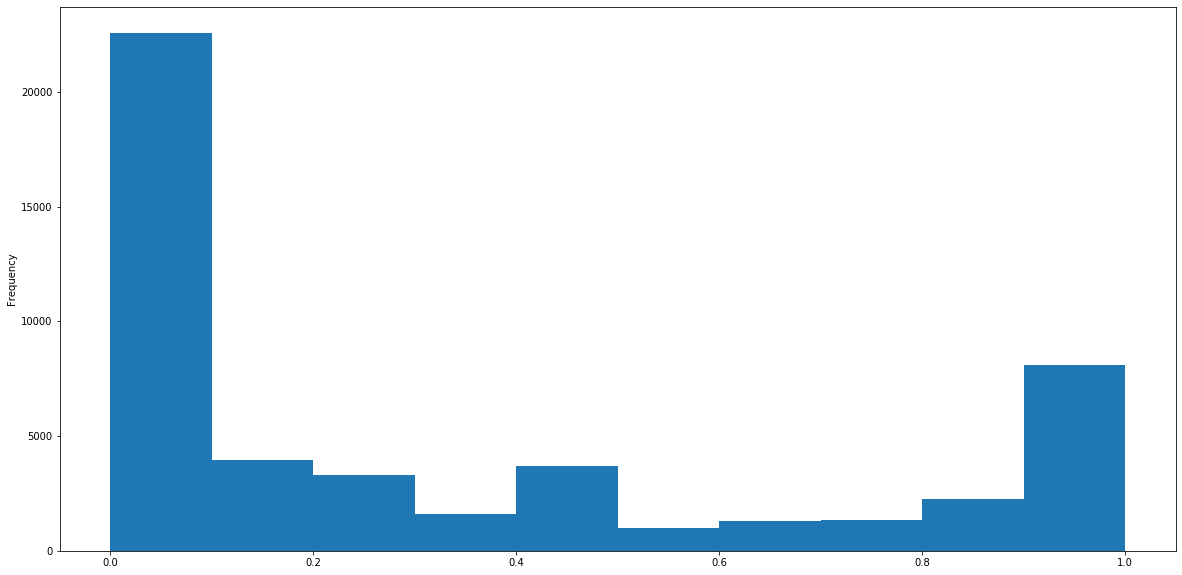

In [49]:
plt = listings_merge.available_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Even in a low season like winter, there seems to be low availability.</p>

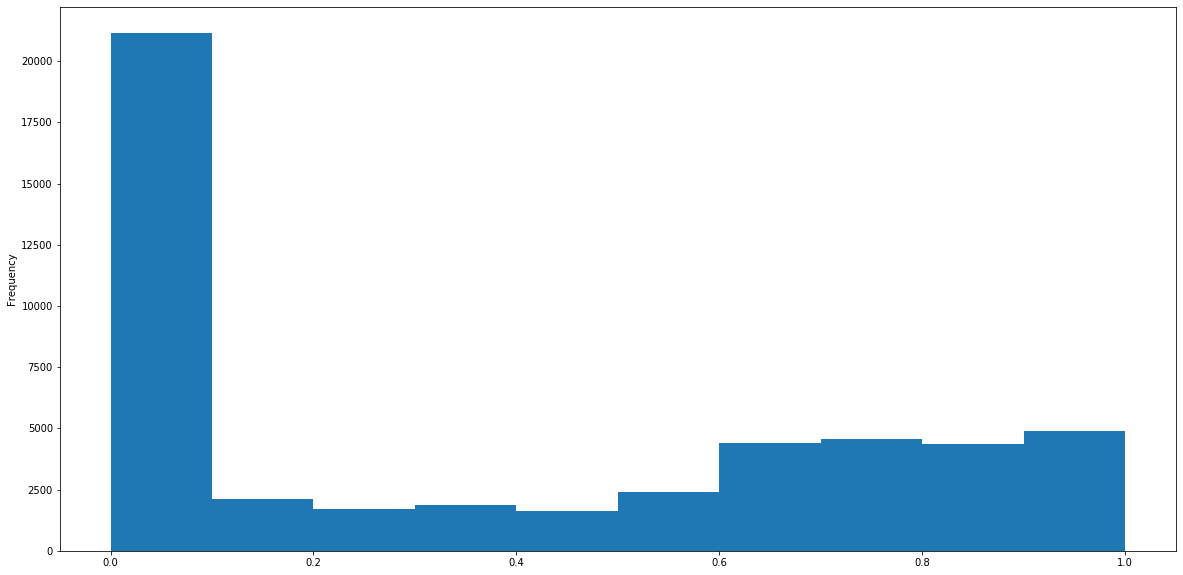

In [44]:
plt = listings_merge.available_winter_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Plotting the log of the minimum nights required we see that it approximates an exponential distribution.</p>

1.000000     11881
2.000000     10844
3.000000      7270
30.000000     3796
4.000000      3057
             ...  
2.989011         1
2.780822         1
12.372603        1
3.331507         1
21.005479        1
Name: min_nights_year_avg, Length: 1553, dtype: int64
30.000000    3796
7.000000     1895
6.000000      691
14.000000     517
10.000000     458
             ... 
13.750685       1
9.331507        1
9.805479        1
28.002740       1
9.013699        1
Name: min_nights_year_avg, Length: 672, dtype: int64


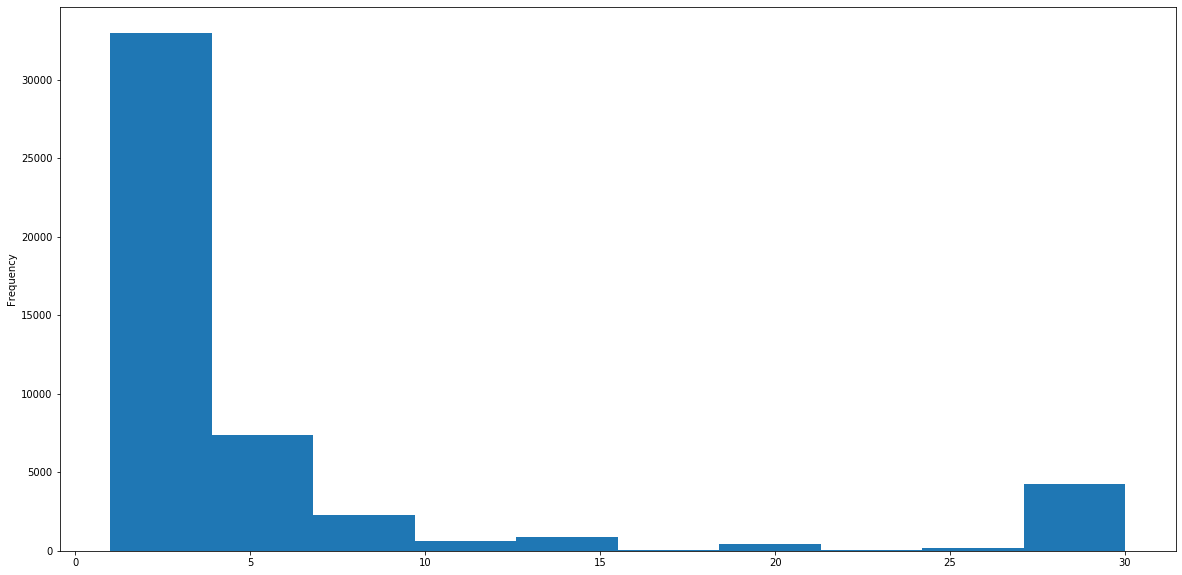

In [45]:
min_nights_75_perc = listings_merge.loc[listings_merge.min_nights_year_avg > 5].min_nights_year_avg.value_counts()
print(listings_merge.min_nights_year_avg.value_counts())
print(min_nights_75_perc)
plt = listings_merge.min_nights_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>There isn't much detail in plot of average prices over the year.  We can't plot the log of average prices due to some zero values that need to be cleaned up.</p>

150.000000    904
100.000000    829
200.000000    682
50.000000     573
60.000000     538
             ... 
294.345205      1
629.589041      1
133.849315      1
56.531507       1
41.709589       1
Name: price_year_avg, Length: 24070, dtype: int64
200.000000    682
250.000000    451
300.000000    245
225.000000    171
350.000000    166
             ... 
246.063014      1
501.484932      1
212.421918      1
250.098630      1
405.224658      1
Name: price_year_avg, Length: 7097, dtype: int64


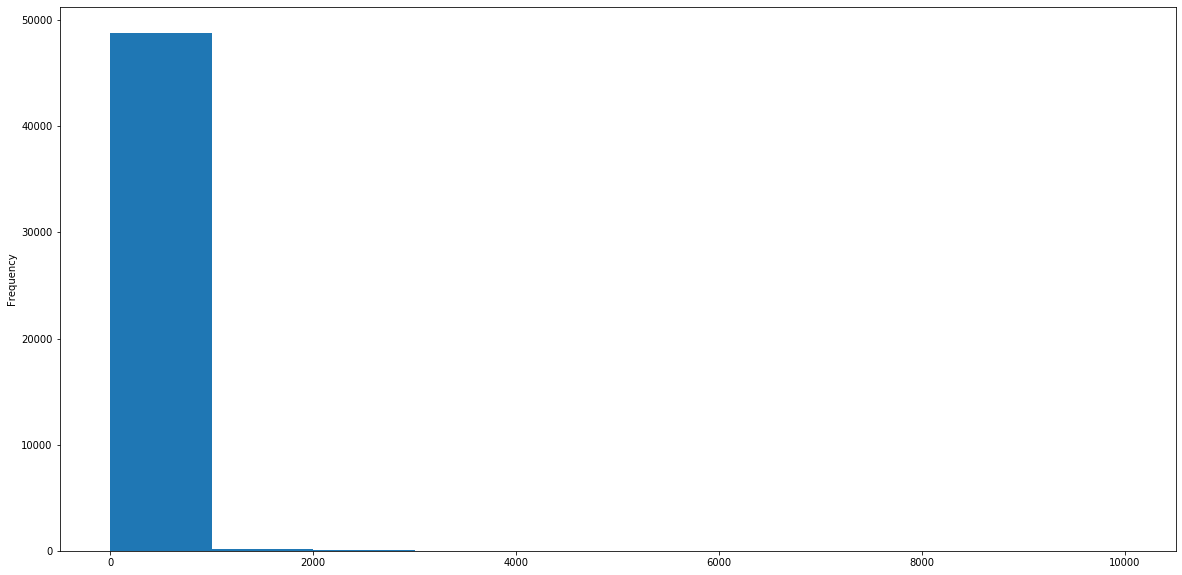

In [46]:
price_75_perc = listings_merge.loc[listings_merge.price_year_avg > 180].price_year_avg.value_counts()
print(listings_merge.price_year_avg.value_counts())
print(price_75_perc)
plt = listings_merge.price_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Use a similar method as with the <b>listings_clean</b> table to average over a 200 m radius from listings that have 0, missing, or outlier values for prices.</p>

In [57]:
print(listings_merge.columns)
print(listings_merge.columns[26], listings_merge.columns[27], listings_merge.columns[28],
      listings_merge.columns[29], listings_merge.columns[30], listings_merge.columns[31],
      listings_merge.columns[32], listings_merge.columns[33]
     )

Index(['id', 'neighbourhood', 'neighbourhood_group', 'latitude', 'longitude',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'available_year_avg', 'available_winter_avg', 'available_spring_avg',
       'available_summer_avg', 'available_fall_avg', 'available_jan_avg',
       'available_jun_avg', 'available_dec_avg', 'min_nights_year_avg',
       'min_nights_winter_avg', 'min_nights_spring_avg',
       'min_nights_summer_avg', 'min_nights_fall_avg', 'min_nights_jan_avg',
       'min_nights_jun_avg', 'min_nights_dec_avg', 'price_year_avg',
       'price_winter_avg', 'price_spring_avg', 'price_summer_avg',
       'price_fall_avg', 'price_jan_avg', 'price_jun_avg', 'price_dec_avg'],
      dtype='object')
price_year_avg price_winter_avg price_spring_avg price_summer_avg price_fall_avg price_jan_avg price_jun_avg price_dec_avg


In [58]:
listings_merge.head()

,id,neighbourhood,neighbourhood_group,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
0,2595,Midtown,Manhattan,40.75362,-73.98377,Entire home/apt,1,1.0,0.0,1.0,...,10.0,10.0,196.334247,177.255556,176.152174,215.728261,216.0,175.000000,215.1,181.548387
1,3831,Clinton Hill,Brooklyn,40.68514,-73.95976,Entire home/apt,3,1.0,1.0,4.0,...,1.0,1.0,86.224658,88.911111,86.032609,85.000000,85.0,86.516129,85.0,91.645161
2,5099,Murray Hill,Manhattan,40.74767,-73.97500,Entire home/apt,2,1.0,1.0,1.0,...,3.0,3.0,206.164384,225.000000,200.000000,200.000000,200.0,216.129032,200.0,256.451613
4,5178,Hell's Kitchen,Manhattan,40.76489,-73.98493,Private room,2,1.0,1.0,1.0,...,2.0,2.0,78.279452,77.233333,77.869565,79.000000,79.0,76.322581,79.0,79.000000
5,5203,Upper West Side,Manhattan,40.80178,-73.96723,Private room,1,1.0,1.0,1.0,...,2.0,2.0,78.106849,75.222222,77.163043,80.000000,80.0,75.000000,80.0,75.645161


<br/>
<p>Similar to how we handled <b>bedrooms</b>, we will average price over 200m radius from listings that have 0 or NaN values.  We will also consider any listings with pricing over $1000 to be outliers, but instead of dropping them, we will also average over 200m radius.  Again we will not consider <b>room_type</b></p>

In [59]:
# https://gizmodo.com/how-precise-is-one-degree-of-longitude-or-latitude-1631241162
# averaging over approximate radius of 200 m from listings
# that have 0, NaN, or greater than threshold price values

lat_diff = 0.002
long_diff = 0.002
def avg_of_neighbors_2(row, col_name, col_index, thresh):
    item = row[col_index]
    room_type = row[5]
    lat = row[3]
    long = row[4]
    if item == 0 or math.isnan(item) or item > thresh:
        item = listings_merge[col_name].loc[(listings_clean.latitude > lat - lat_diff) \
            & (listings_merge.latitude < lat + lat_diff) \
            & (listings_merge.longitude > long - long_diff) \
            & (listings_merge.longitude < long + long_diff)].groupby(by=listings_merge.neighbourhood).mean().round()[0]
        row[col_index] = item
    return row

listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_year_avg', col_index=26, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_winter_avg', col_index=27, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_spring_avg', col_index=28, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_summer_avg', col_index=29, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_fall_avg', col_index=30, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_jan_avg', col_index=31, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_jun_avg', col_index=32, axis=1, thresh=1000)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_dec_avg', col_index=33, axis=1, thresh=1000)


<br/>
<p>After some cleanup and taking the log of prices averaged over the year, we see an approximate normal distribution.</p>

5.010635    906
4.605170    829
5.298317    685
3.912023    573
4.094345    538
           ... 
5.506734      1
4.818291      1
6.393843      1
4.179223      1
4.052237      1
Name: price_year_avg, Length: 23973, dtype: int64


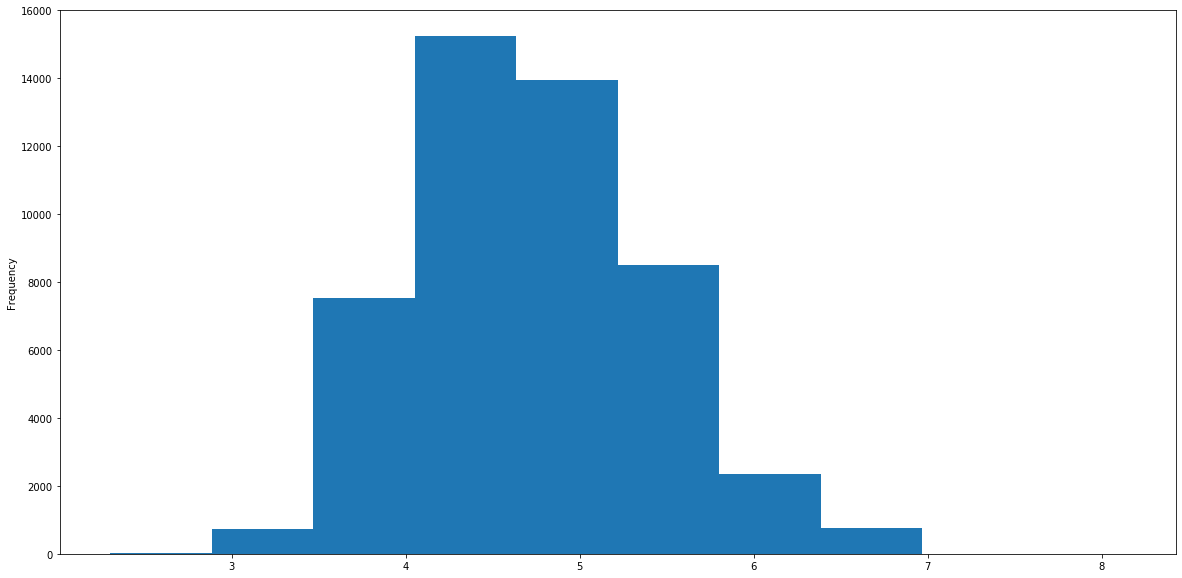

In [62]:
print(np.log(listings_merge.price_year_avg).value_counts())
plt = np.log(listings_merge.price_year_avg).plot(kind='hist', figsize=(20, 10))

<br/>
<p>Even after the cleaning process, we find that there is still a missing <b>price_fall_avg</b> value.  Averaging over nearest neighbors didn't catch everything!</p>

In [63]:
listings_merge.info()
listings_merge.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49093 entries, 0 to 50586
Data columns (total 34 columns):
id                       49093 non-null int64
neighbourhood            49093 non-null object
neighbourhood_group      49093 non-null object
latitude                 49093 non-null float64
longitude                49093 non-null float64
room_type                49093 non-null object
accommodates             49093 non-null int64
bathrooms                49093 non-null float64
bedrooms                 49093 non-null float64
beds                     49093 non-null float64
available_year_avg       49093 non-null float64
available_winter_avg     49093 non-null float64
available_spring_avg     49093 non-null float64
available_summer_avg     49093 non-null float64
available_fall_avg       49093 non-null float64
available_jan_avg        49093 non-null float64
available_jun_avg        49093 non-null float64
available_dec_avg        49093 non-null float64
min_nights_year_avg      49093 non

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,available_year_avg,available_winter_avg,available_spring_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,4.909300e+04,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,...,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000,49093.000000
mean,2.127764e+07,40.728665,-73.950545,2.863402,1.141741,1.176359,1.542175,0.325108,0.372058,0.366838,...,5.582033,5.524875,145.389290,139.792393,144.937544,147.167450,147.546258,136.256909,147.798276,145.966978
std,1.238717e+07,0.055167,0.047786,1.874527,0.402948,0.737412,1.069205,0.373005,0.369736,0.448132,...,8.200071,8.083301,124.263301,116.549218,123.631036,125.055762,132.880985,113.781960,126.750960,123.779300
min,2.595000e+03,40.499790,-74.247870,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
25%,1.005783e+07,40.689310,-73.982770,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.258065,69.000000,66.755556,69.000000,70.000000,70.000000,65.225806,70.000000,69.000000
50%,2.139409e+07,40.722820,-73.954890,2.000000,1.000000,1.000000,1.000000,0.167123,0.277778,0.043478,...,2.266667,2.290323,109.000000,105.677778,108.282609,110.000000,110.000000,103.000000,110.000000,110.000000
75%,3.257305e+07,40.763100,-73.934100,4.000000,1.000000,1.000000,2.000000,0.668493,0.733333,1.000000,...,5.000000,5.000000,179.123288,175.000000,179.000000,180.000000,180.000000,169.032258,180.000000,180.000000
max,4.058402e+07,40.916860,-73.712990,22.000000,5.000000,10.000000,12.000000,1.000000,1.000000,1.000000,...,30.000000,30.000000,3406.000000,3406.000000,3406.000000,3406.000000,5673.000000,3406.000000,3406.000000,3406.000000


In [64]:
listings_merge_backup = listings_merge

In [65]:
listings_merge = listings_merge_backup

<p>Drop non-numerical columns as well as listing IDs (which do not have any meaning for modeling).</p>

In [66]:
neighbourhood_group_one_hot = pd.get_dummies(listings_merge.neighbourhood_group)
listings_merge = listings_merge.join(neighbourhood_group_one_hot)
listings_merge['entire_home_apt'] = np.where(listings_merge.room_type == 'Entire home/apt', 1, 0)

listings_merge = listings_merge.drop([
    'id', 'room_type', 'neighbourhood', 'neighbourhood_group'
], axis=1)


<br/>
<p>Let's do a final check for any correlated features.</p>

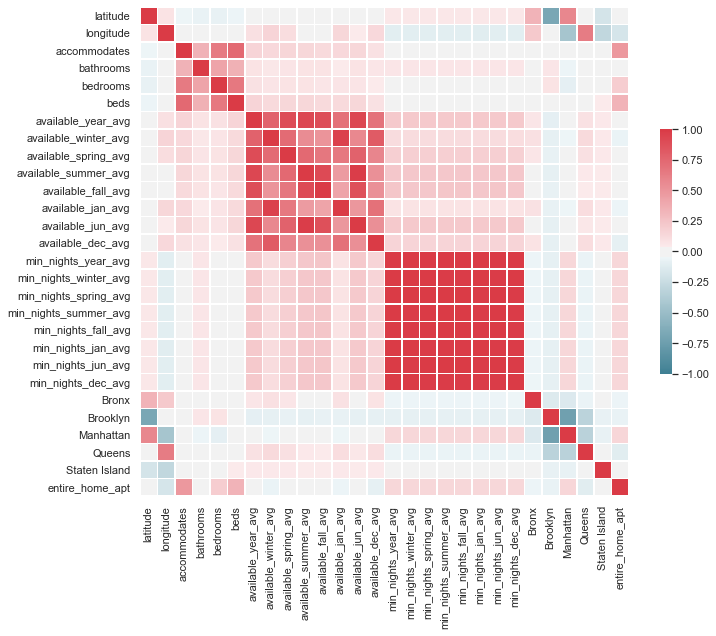

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

features = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg'
], axis=1)

fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(features.corr(), cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

<p>We can see that <b>beds</b> and <b>accommodates</b> are heavily correlated with <b>bedrooms</b>.  We can drop those columns.</p>

In [69]:
listings_merge = listings_merge.drop(['beds', 'accommodates'], axis=1)

<p>Perhaps we can add more features like monthly or holiday averages for availability, minimum nights required, and price, but that would make the table size explode!<p>

<h2>Modeling data with prices as target labels</h2>

<p>Now that we've cleaned up the data, let's look at several possible models of linear and non-linear type.  We will use average price of each listing over the year 2019, as well as seasonal average price as the target labels.  The easiest ones to get started with are Linear Regression and Random Forest.</p>

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
], axis=1)
combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
    ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
    ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
    ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
    ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
    ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
    ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
    ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

scaler = StandardScaler()

for combo in combo_list:
    y = listings_merge[combo[2]]
    X_temp = X_base
    X_temp[combo[0]] = listings_merge[combo[0]]
    X_temp[combo[1]] = listings_merge[combo[1]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.25, random_state=42, shuffle=True)
    print('Target label:', combo[2])

#     clf = LinearRegression()
#     clf.fit(scaler.fit_transform(X_train), y_train)
#     print("Linear regression score:", clf.score(scaler.transform(X_test), y_test))
#     clf2 = RandomForestRegressor()
#     clf2.fit(scaler.fit_transform(X_train), y_train)
#     print("Random forest score:", clf2.score(scaler.transform(X_test), y_test))
    
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    print("Linear regression score:", clf.score(X_test, y_test))
    clf2 = RandomForestRegressor()
    clf2.fit(X_train, y_train)
    print("Random forest score:", clf2.score(X_test, y_test))

Target label: price_year_avg
Linear regression score: 0.43183094322374715
Random forest score: 0.6044850930345683
Target label: price_winter_avg
Linear regression score: 0.42986646465928935
Random forest score: 0.5881523665833551
Target label: price_spring_avg
Linear regression score: 0.43973136137579044
Random forest score: 0.605923170493607
Target label: price_summer_avg
Linear regression score: 0.44890458218684903
Random forest score: 0.6177781894923073
Target label: price_fall_avg
Linear regression score: 0.38271874843111203
Random forest score: 0.6284568817788858
Target label: price_jan_avg
Linear regression score: 0.4115785582806456
Random forest score: 0.554859176279432
Target label: price_jun_avg
Linear regression score: 0.44706406038948154
Random forest score: 0.6180539630284516
Target label: price_dec_avg
Linear regression score: 0.44312892043005025
Random forest score: 0.6195466885592207


<p>We can see that Random Forest performs much better than Linear Regression in terms of R<sup>2</sup> score.</p>

<br/>
<p>Try optimizing some of the parameters using GridSearchCV.</p>

In [65]:
print(clf2.base_estimator_)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')


In [ ]:
from sklearn.model_selection import GridSearchCV

X = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'available_winter_avg', 'available_spring_avg', 'available_summer_avg', 'available_fall_avg',
    'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg', 'min_nights_fall_avg'
], axis=1)

y = listings_merge['price_year_avg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42, shuffle=True)
clf = RandomForestRegressor()

params = {
    'max_depth': [6, 8, 10, 12],
    'min_samples_split': [4, 8, 16],
    'min_samples_leaf': [4, 8, 16],
    'max_features': [2, 4, 6]
}
grid = GridSearchCV(clf, param_grid=params, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

In [134]:
X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg'
], axis=1)
combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
    ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
    ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
    ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
    ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg']
]
best_params = grid.best_params_

for combo in combo_list:
    y = listings_merge[combo[2]]
    X_temp = X_base
    X_temp[combo[0]] = listings_merge[combo[0]]
    X_temp[combo[1]] = listings_merge[combo[1]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.25, random_state=42, shuffle=True)

    clf = RandomForestRegressor(
        max_depth=best_params['max_depth'],
        max_features=best_params['max_features'],
        min_samples_leaf=best_params['min_samples_leaf'],
        min_samples_split=best_params['min_samples_split']
    )
    clf.fit(X_train, y_train)
    print('Target label:', combo[2])
    print('Modified param random forest score:', clf.score(X_test, y_test))


Target label: price_year_avg
Modified param random forest score: 0.584063743543527
Target label: price_winter_avg
Modified param random forest score: 0.5617586715318124
Target label: price_spring_avg
Modified param random forest score: 0.5880588501816182
Target label: price_summer_avg
Modified param random forest score: 0.5944569767209051
Target label: price_fall_avg
Modified param random forest score: 0.5685782880088177


<p>Our modified parameter Random Forest scores are essentially no better than with default parameters.</p>

<p>Perhaps there will be an incremental improvement in R<sup>2</sup> by using Gradient Boosting (XGBoost in this case).</p>

In [74]:
from xgboost.sklearn import XGBRegressor

X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
], axis=1)
combo_list = [
#     ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
#     ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
    ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
    ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
    ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    y = listings_merge[combo[2]]
    X_temp = X_base
    X_temp[combo[0]] = listings_merge[combo[0]]
    X_temp[combo[1]] = listings_merge[combo[1]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.25, random_state=42, shuffle=True)

    clf = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.1,
        max_depth=8,
        n_estimators=100,
        cv=5
    )

#     clf.fit(scaler.fit_transform(X_train), y_train)
#     print('Target label:', combo[2])
#     print('XGBoost score:', clf.score(scaler.transform(X_test), y_test))

    clf.fit(X_train, y_train)
    print('Target label:', combo[2])
    print('XGBoost score:', clf.score(X_test, y_test))

/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Target label: price_jan_avg
XGBoost score: 0.5433512738098216


/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Target label: price_jun_avg
XGBoost score: 0.6153717604300137


/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Target label: price_dec_avg
XGBoost score: 0.6250296946488384


<p>We get decent scores from a Gradient Boost model.</p>

<p>Will polynomial regression provide any benefit?  Let's find out.</p>

In [76]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
], axis=1)
combo_list = [
#     ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
#     ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
    ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
    ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
    ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    y = listings_merge[combo[2]]
    X_temp = X_base
    X_temp[combo[0]] = listings_merge[combo[0]]
    X_temp[combo[1]] = listings_merge[combo[1]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.25, random_state=42, shuffle=True)

    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    clf = LinearRegression()
    clf.fit(X_train_poly, y_train)
    print('Target label:', combo[2])
    print(clf.score(X_test_poly, y_test))

Target label: price_jan_avg
0.47353041594664486
Target label: price_jun_avg
0.5206383172409412
Target label: price_dec_avg
0.5211448769117493


In [75]:
from sklearn.preprocessing import PolynomialFeatures
from xgboost.sklearn import XGBRegressor

X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
], axis=1)
combo_list = [
#     ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
#     ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
    ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
    ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
    ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    y = listings_merge[combo[2]]
    X_temp = X_base
    X_temp[combo[0]] = listings_merge[combo[0]]
    X_temp[combo[1]] = listings_merge[combo[1]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=.25, random_state=42, shuffle=True)

    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    clf = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.1,
        max_depth=8,
        n_estimators=100,      
    )
    clf.fit(X_train_poly, y_train)
    print('Target label:', combo[2])
    print(clf.score(X_test_poly, y_test))

/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Target label: price_jan_avg
0.5433020255704233


/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Target label: price_jun_avg
0.6133626385054366


/Users/blai/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Target label: price_dec_avg
0.622320729995511


<p>It's odd that the fall price average model has such a terrible score compared to the rest for second degree Polynomial Feature Transform + Linear Regresssion.  Second degree Polynomial Feature Transform + Gradient Boosting performs close but no better than Gradient Boosting alone.</p>